In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer

In [2]:
pd.pandas.set_option('display.max_rows', None)
data = pd.read_csv(r'D:\PycharmProjects\nlp\data\drug_text_data\train_F3WbcTw.csv')
data.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [3]:
print('The size of the dataset is {}'.format(data.shape))
print('Total unique values in unique_hash is {}'.format(len(np.unique(data['unique_hash']))))

The size of the dataset is (5279, 4)
Total unique values in unique_hash is 5279


In [4]:
data = data.iloc[:, 1:4]
data.head()

,text,drug,sentiment
0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,I can completely understand why you’d want to ...,gilenya,2
2,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [5]:
data['drug'].value_counts()

ocrevus                         676
gilenya                         666
ocrelizumab                     441
entyvio                         303
humira                          270
fingolimod                      238
remicade                        229
opdivo                          224
tarceva                         218
cladribine                      200
keytruda                        199
stelara                         161
tagrisso                        161
alimta                          146
lucentis                         67
eylea                            65
avastin                          52
nivolumab                        50
cimzia                           48
crizotinib                       43
alectinib                        43
vitrectomy                       41
simponi                          39
erlotinib                        35
tecentriq                        34
xalkori                          33
pemetrexed                       33
osimertinib                 

In [6]:
data = data[(data['drug'] == 'ocrevus') |
            (data['drug'] == 'gilenya') | (data['drug'] == 'ocrelizumab')
            | (data['drug'] == 'entyvio') |
            (data['drug'] == 'humira') | (data
                                          ['drug'] == 'fingolimod') | (data['drug'] == 'remicade') | (
                        data['drug'] == 'opdivo') | (data['drug'] == 'tarceva') | (data['drug'] == 'cladribine')]

In [7]:
data['drug'].value_counts()

ocrevus        676
gilenya        666
ocrelizumab    441
entyvio        303
humira         270
fingolimod     238
remicade       229
opdivo         224
tarceva        218
cladribine     200
Name: drug, dtype: int64

In [8]:
# segregating dataframe for analyzing individual condition
data_ocrevus = data[(data['drug'] == 'ocrevus')]
data_gilenya = data[(data['drug'] == 'gilenya')]
data_ocrelizumab = data[(data['drug'] == 'ocrelizumab')]
data_entyvio = data[(data['drug'] == 'entyvio')]
data_humira = data[(data['drug'] == 'humira')]
data_fingolimod = data[(data['drug'] == 'fingolimod')]
data_remicade = data[(data['drug'] == 'remicade')]
data_opdivo = data[(data['drug'] == 'opdivo')]
data_tarceva = data[(data['drug'] == 'tarceva')]
data_cladribine = data[(data['drug'] == 'cladribine')]

Text(0.5, 1.0, 'Word cloud for crevus')

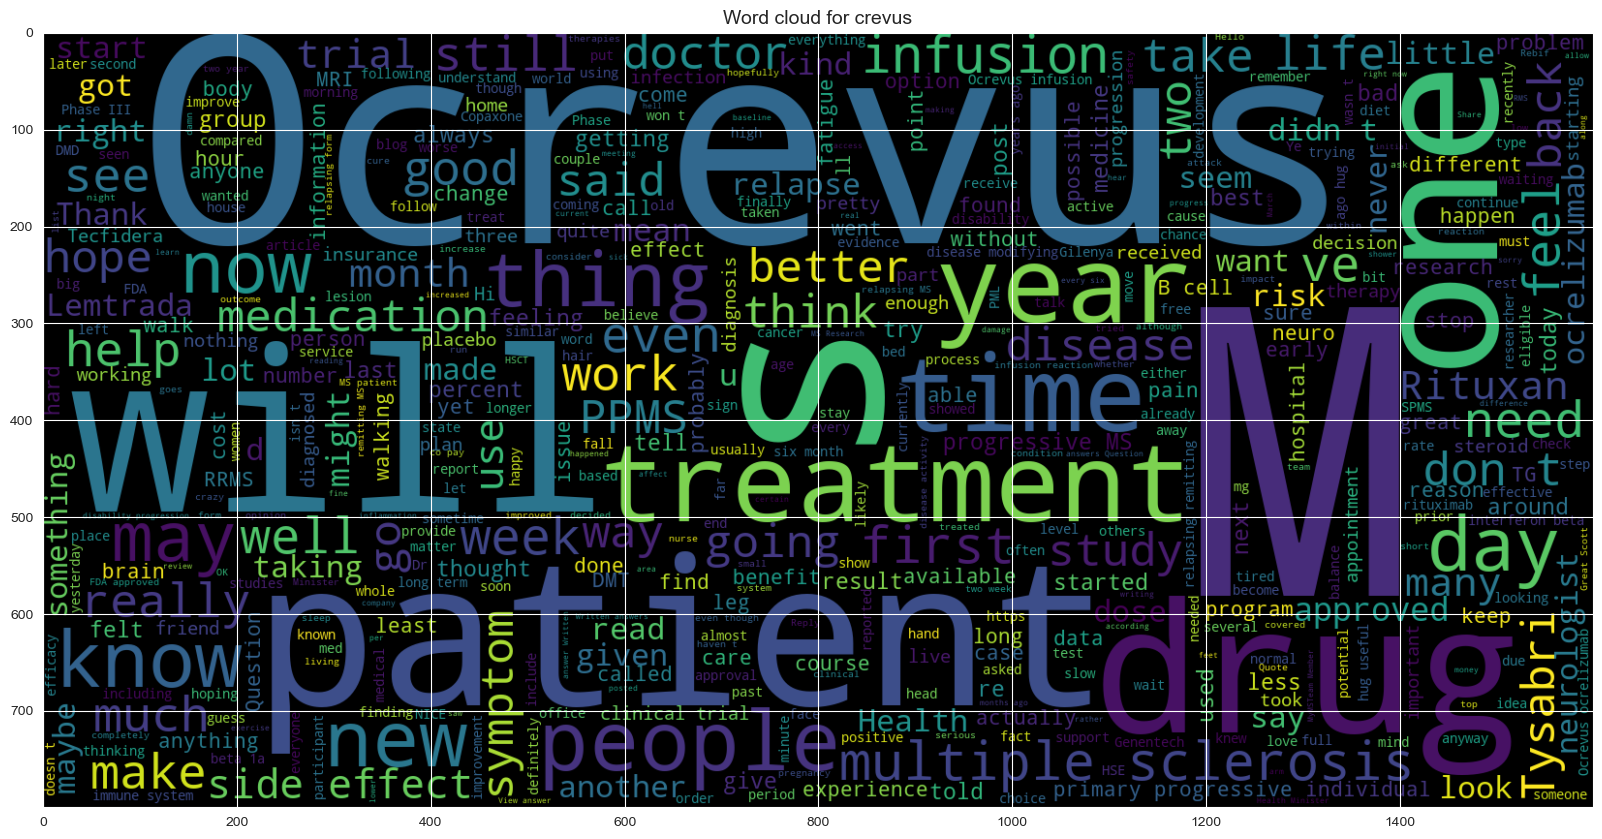

In [10]:
# %matplotlib inline

from wordcloud import WordCloud

plt.figure(figsize=(20, 20))  # Text that is Fake News Headlines
wc = WordCloud(max_words=500, width=1600, height=800).generate(" ".join(data_ocrevus.text))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word cloud for crevus', fontsize=14)

In [11]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
def clean_data(raw_data):  # 用机器学习模型，分析 1、切词对模型的影响 2、停用词 3、归一化
    # 1. Delete HTML 
    text = BeautifulSoup(raw_data, 'html.parser').get_text()
    # 2. Make a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    # 3. lower letters
    text = text.lower().split()  # 1、这里用的是python自带的分词，以空格来隔开，用nltk切词和自己训练的切词自己试试，替换一下
    # 5. Stopwords 
    meaningful_text = [w for w in text if not w in stop]  # 2、去除停用词对模型有无影响，试试
    # 6. lemmitization
    lemmatizer = WordNetLemmatizer()
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_text]  # 3、归一化是够有作用
    # 7. space join words
    return (' '.join(lemmitize_words))

In [14]:
nltk.download()
data['updated_text'] = data['text'].apply(clean_data)

LookupError: 
**********************************************************************
  Resource [93momw-1.4[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('omw-1.4')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/omw-1.4[0m

  Searched in:
    - 'C:\\Users\\Bugs_Xie/nltk_data'
    - 'D:\\miniconda3\\envs\\nlp\\nltk_data'
    - 'D:\\miniconda3\\envs\\nlp\\share\\nltk_data'
    - 'D:\\miniconda3\\envs\\nlp\\lib\\nltk_data'
    - 'C:\\Users\\Bugs_Xie\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [15]:
data.head()

,text,drug,sentiment,updated_text
0,Autoimmune diseases tend to come in clusters. ...,gilenya,2,autoimmune disease tend come cluster gilenya f...
1,I can completely understand why you’d want to ...,gilenya,2,completely understand want try result reported...
2,Interesting that it only targets S1P-1/5 recep...,fingolimod,2,interesting target p receptor rather like fing...
3,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2,interesting grand merci wonder lemtrada ocrevu...
4,"Hi everybody, My latest MRI results for Brain ...",gilenya,1,hi everybody latest mri result brain cervical ...


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['ocrevus', 'gilenya', 'ocrelizumab', 'entyvio', 'humira', 'fingolimod', 'remicade', 'opdivo', 'tarceva',
        'cladribine'])
# data['drug'] = le.transform(data['drug'])

In [17]:
x = data['updated_text']
y = data['drug']

In [18]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42) # 15%作为测试，自己读csv作为测试集

print(f'Rows in train set: {len(x_train)}\nRows in test set: {len(x_test)}')

Rows in train set: 2945
Rows in test set: 520


In [19]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=42) # 15%作为验证，train读进来的只作为训练和验证

print(f'Rows in train set: {len(x_train)}\nRows in valid set: {len(x_valid)}')

Rows in train set: 2503
Rows in valid set: 442


In [ ]:
# n-fold CV

In [20]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv  = CountVectorizer(max_features=2500)
x_train = cv.fit_transform(x_train).toarry()
x_valid = cv.fit_transform(x_valid).toarry()
x_test = cv.fit_transform(x_test).toarry()


In [ ]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(learning_rate=0.01, min_child_weight=3, reg_alpha=0.3, subsample=0.8, random_state=42,gamma=5,)
xgb_classifier.fit(x_train, y_train, early_stopping_rounds=40, eval_set=[(x_)])

              precision    recall  f1-score   support

           0       1.00      0.86      0.93       155
           1       0.79      1.00      0.88       208
           2       0.95      0.99      0.97       170
           3       0.97      1.00      0.99       494
           4       0.87      0.81      0.84       187
           5       0.99      1.00      1.00       317
           6       1.00      1.00      1.00       490
           7       0.99      1.00      1.00       159
           8       1.00      0.74      0.85       170
           9       1.00      0.99      1.00       153

    accuracy                           0.96      2503
   macro avg       0.96      0.94      0.94      2503
weighted avg       0.96      0.96      0.96      2503

[[134   0   9  12   0   0   0   0   0   0]
 [  0 208   0   0   0   0   0   0   0   0]
 [  0   0 168   0   0   2   0   0   0   0]
 [  0   0   0 493   0   0   1   0   0   0]
 [  0  35   0   1 151   0   0   0   0   0]
 [  0   0   0   0   0 317 